In [1]:
import keras
import tensorflow as tf
import sklearn
import os, shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Set seed for reproducibility
np.random.random(2020)


# load the data from your local computer
test_dir = 'C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Computer Programming/Data Science/Machine_Learning+Data_Science_NLP/ZINDI DATA SCIENCE COMPETITIONS/SPOT THE MASK CHALLENGE/test_dir'
val_dir = 'C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Computer Programming/Data Science/Machine_Learning+Data_Science_NLP/ZINDI DATA SCIENCE COMPETITIONS/SPOT THE MASK CHALLENGE/val_dir'
partial_train_dir = 'C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Computer Programming/Data Science/Machine_Learning+Data_Science_NLP/ZINDI DATA SCIENCE COMPETITIONS/SPOT THE MASK CHALLENGE/par_train_dir'

# partial_train + val_dir
train_dir = 'C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Computer Programming/Data Science/Machine_Learning+Data_Science_NLP/ZINDI DATA SCIENCE COMPETITIONS/SPOT THE MASK CHALLENGE/train'


In [3]:
# Create a subfolder
partial_train_mask_dir = os.path.join(partial_train_dir, 'mask')
partial_train_nomask_dir = os.path.join(partial_train_dir, 'nomask')

train_mask_dir = os.path.join(train_dir, 'mask')
train_nomask_dir = os.path.join(train_dir, 'nomask')

test_mask_dir = os.path.join(test_dir, 'mask')
test_nomask_dir = os.path.join(test_dir, 'nomask')

val_mask_dir = os.path.join(val_dir, 'mask')
val_nomask_dir = os.path.join(val_dir, 'nomask')

In [4]:
print('total training mask images:', len(os.listdir(train_mask_dir)))
print('total training nomask images:', len(os.listdir(train_nomask_dir)))

print('\ntotal partial training mask images:', len(os.listdir(partial_train_mask_dir)))
print('total partial training nomask images:', len(os.listdir(partial_train_nomask_dir)))

print('\ntotal test mask images:', len(os.listdir(test_mask_dir)))
print('total test nomask images:', len(os.listdir(test_nomask_dir)))

print('\ntotal validation mask images:', len(os.listdir(val_mask_dir)))
print('total validation nomask images:', len(os.listdir(val_nomask_dir)))

total training mask images: 641
total training nomask images: 667

total partial training mask images: 466
total partial training nomask images: 534

total test mask images: 267
total test nomask images: 242

total validation mask images: 175
total validation nomask images: 133


# Build the model
from keras import layers, models
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3),activation='relu',padding='same',input_shape=(150,150,3)))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

# block 2
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

# block 3
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

# block 4
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

# block 5
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# Data Processing
from keras.preprocessing.image import ImageDataGenerator
np.random.random(2020)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(partial_train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
val_generator = test_datagen.flow_from_directory(val_dir, target_size=(150,150), batch_size=20, class_mode='binary')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

In [5]:
from keras.applications import VGG16
conv_base = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', input_shape=(150,150,3), include_top=False)

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size, class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i+=1
        if i* batch_size>=sample_count:
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(partial_train_dir, 1000)
validation_features, validation_labels = extract_features(val_dir, 308)
test_features, test_labels = extract_features(test_dir, 509)

Found 1000 images belonging to 2 classes.
Found 308 images belonging to 2 classes.
Found 509 images belonging to 2 classes.


In [8]:
train_features = np.reshape(train_features, (1000, 4*4*512))
validation_features = np.reshape(validation_features, (308,4*4*512))
test_features = np.reshape(test_features, (509, 4*4*512))

In [9]:
# Build the classifier
from keras  import models, layers, optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(4*4*512,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
from keras import optimizers
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

# Train the model
history = model.fit(train_features, train_labels,validation_data=(validation_features, validation_labels), epochs=30, batch_size=20)

Train on 1000 samples, validate on 308 samples
Epoch 1/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6972 - acc: 0.5190 - val_loss: 0.6897 - val_acc: 0.5195
Epoch 2/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6813 - acc: 0.5630 - val_loss: 0.6657 - val_acc: 0.6429
Epoch 3/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6577 - acc: 0.6220 - val_loss: 0.6300 - val_acc: 0.7305
Epoch 4/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6401 - acc: 0.6370 - val_loss: 0.5945 - val_acc: 0.7565
Epoch 5/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6006 - acc: 0.6970 - val_loss: 0.5522 - val_acc: 0.7532
Epoch 6/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5551 - acc: 0.7480 - val_loss: 0.5327 - val_acc: 0.7565
Epoch 7/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5114 - acc: 0.7680 - val_loss: 0.5046 - val_acc: 0.7695
Epoch 8/30
1000

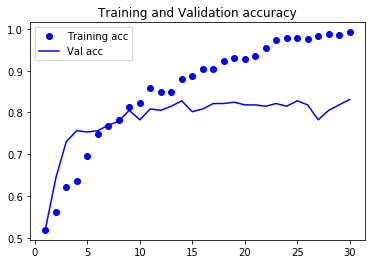

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Val acc')
plt.title('Training and Validation accuracy')
plt.legend(loc='best')
plt.show()


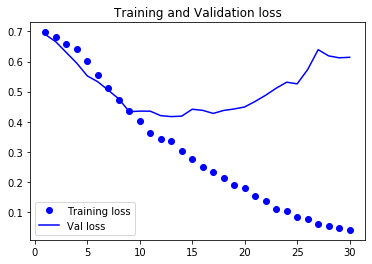

In [11]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Val loss')
plt.title('Training and Validation loss')
plt.legend(loc='best')
plt.show()

In [12]:
model.evaluate(test_features, test_labels)

509/509 [==============================] - 0s 333us/step


[0.7061081292118679, 0.7858546376228333]

In [13]:
import pandas as pd
import numpy as np
y_pred = model.predict(test_features)

In [14]:
test_pred = (y_pred > .5).astype(int)
test_pred = test_pred.reshape(509,)
test_pred.shape

(509,)

In [15]:
test_pred

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,

In [16]:
# Submission file
import os
import pandas as pd

files_in_test = sorted(os.listdir(test_mask_dir))
files_in_test_2 = sorted(os.listdir(test_nomask_dir))
files = files_in_test + files_in_test_2

images=[i for i in files]

df = pd.DataFrame()
df['images']=[test_dir+str(x) for x in images]
df['target'] = test_pred
df.to_csv('Facemask prediction_1.csv', index=False)

In [17]:
result = pd.read_csv('Facemask prediction_1.csv')
result

,images,target
0,C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Co...,1
1,C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Co...,0
2,C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Co...,0
3,C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Co...,1
4,C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Co...,0
...,...,...
504,C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Co...,1
505,C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Co...,0
506,C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Co...,0
507,C:/Users/ADEMOLA/Documents/AYOBAMI_DOCUMENT/Co...,0
